<h1 style="text-align:center;">NASLOV</h1>

## 1. Uvod

U ovoj zadaći definirat ćemo osnovne pojmove teorije grafova, opisat ćemo problem pretraživanja, te ćemo demonstrirati par algoritama za traženje puteva u grafu i probat ćemo usporediti njihove složenosti.

Jedan od najpoznatijih problema *teorije grafova* vezan je uz stari pruski grad K&ouml;nigsberg koji se nalazi na rijeci Pregel. Naime, dio grada smješten je na dva rječna otoka koji su sa sedam mostova povezani s kopnom i međusobno.

<div style="text-align: center;">
    <img src="https://www.cse.buffalo.edu/~rapaport/191/7bridges.jpg" width=400 height=400>
    <em>Slika 1.1. Tlocrt grada</em>
</div>

Građane K&ouml;nigsberga mučilo je sljedeće pitanje: "Može li se naći staza takva da prijeđemo svih 7 mostova i da svaki most prijeđemo najviše jednom?". Rješenje za navedeni problem dao je švicarski matematičar *Leonhard Euler* (1707.–1783.) 1736. godine, a time ujedno i postavio temelje *teorije grafova*.

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 1.1.** Graf $G$ je uređeni par $G = (V, E)$, gdje je $V$ neprazan skup *vrhova*, a $E$ je skup *bridova*. Svaki brid $e \in E$ spaja dva vrha $u, v \in V$ koji se zovu *krajevi* od $e$. Brid čiji se krajevi podudaraju zove se *petlja*, a ako dva ili više brida povezuju isti par vrhova, zovu se *višestruki bridovi*.

</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 1.2.** Graf je *jednostavan* ako ne sadrži ni petlje ni višestruke bridove. Graf koji sadrži višestruke bridove, zove se *multigraf*.

</div>

Sada naš problem možemo pokazati pomoću sljedećeg multigrafa:
<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/K%C3%B6nigsberg_graph.svg/1280px-K%C3%B6nigsberg_graph.svg.png" width=300 height=300>
    <em>Slika 1.2. Pripadni multigraf </em>
</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 1.3.** *Stupanj vrha* je broj bridova s kojima je vrh spojen.

</div>

Vidimo da u našem slučaju stupanj vrha $a$ jednak 5 (dva mosta povezuju s $b$ i $c$ i jedan s $d$). 

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 1.4.** *Šetnja* u grafu $G$ je naizmjeničan niz vrhova i bridova
$$ (v_{0}e_{1}v_{1}e_{2} \dots v_{k-1}e_{k}v_{k}),  $$

pri čemu je 

$$ v_{0}, v_{1}, v_{2}, \dots, v_{k} \in V, $$
$$ e_{0}, e_{1}, e_{2}, \dots, e_{k} \in E. $$

*Staza* je šetnja bez ponovljenih bridova. Ako su početak i kraj šetnje isti vrhovi, tada govorimo o *zatvorenoj šetnji.*
</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 1.5.** *Eulerova staza* grafa $G$ je staza koja prolazi svakim bridom od $G$ točno jednom. *Eulerova tura* je zatvorena Eulerova staza.

</div>

<div style="text-align: center;">
    <img src="https://www.thehindu.com/children/article21247916.ece/alternates/FREE_435/26istb%20Puzzle%201%20Image",
         width=300, height=200>
    <em>Slika 1.3. Najpoznatiji primjer Eulerove staze </em>
</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Teorem 1.6.** *Graf $G$* je Eulerov ako i samo ako mu je svaki vrh parnog stupnja.

</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Korolar 1.7.** *Graf $G$ ima Eulerovu stazu ako i samo ako ima najviše dva vrha neparnog stupnja.*
</div>

U našem grafu imamo 4 čvora koja su neparnog stupnja, dakle iz korolara slijedi da u slučaju K&ouml;nigsberga takva staza ne postoji!

## 2. Pretraživanja u širinu i dubinu
### 2.1. Pretraživanje u širinu
Sada kada smo upoznati s osnovnim pojmovima *teorije grafova* opisat ćemo dva vrlo poznata algoritma, ali za to nam trebaju još neke definicije.

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 2.1.** *Put* je šetnja kojoj su svi vrhovi različiti.

</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 2.2.** Za graf kažemo da je *povezan* ako postoji put između svaka dva vrha.

</div>


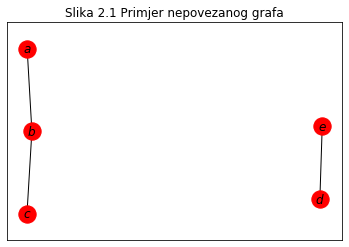

In [341]:
import networkx as nx
import matplotlib.pyplot as plt

# inicijaliziramo graf
graf = nx.Graph()
graf.add_edges_from([(0, 1), (1, 2), (3, 4)])

# ascii vrijednosti pretvorimo u char
node_labels = { i : '$'+chr(97 + i)+'$' for i in range(0, 5) }

# crtam graf
nx.draw_networkx(graf, with_labels=True, labels=node_labels, node_color='red')
plt.title('Slika 2.1.Primjer nepovezanog grafa')
plt.show()

Iz primjera sa slike se lagano vidi da graf nije povezan (npr. ne postoji put između $c$ i $d$), ali kako će računalo provjeriti za zadani graf je li povezan? Ili ako je povezan možda želimo pronaći najkraći put između dva čvora? 
<br><br>
Jedan takav algoritam osmislio je američki profesor Edward F. Moore (1925.-2003.) za svoj problem pronalaženja najkraćeg puta u labirintu. Ime *pretraživanje u širinu* ili *BFS* (*Breadth-first search*) je algoritam dobio po tome što prvo pretražuje sve susjedne čvorove trenutnog čvora, a tek onda za susjede trenutnog čvora provjeri njihove susjede, što na stablu pretraživanja izgleda kao da ide s lijeva na desno, tj. ide u širinu.

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/4/46/Animated_BFS.gif",
         width=300, height=200>
    <em>Animacija 2.2. Pretraživanje u širinu </em>
</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 2.3.** *Ciklus* je šetnja u kojoj su početni i završni kraj jednaki.

</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 2.4.** *Stablo* je graf koji ne sadrži cikluse.

</div>

Pošto želimo da algoritam prvo posjeti sve susjedne trenutnog čvora, a tek onda susjede susjeda, prirodno se nameće da ćemo za strukturu podataka koristiti *red* (*queue*) koja radi na principu *FIFO* (*First in, first out*). Za potrebe ove zadaće ćemo implementirati klasu *Spremnik* koju će klasa *Queue* nasljeđivati, a kasnije i *stog* (*Stack*) koji radi na principu *FILO* (*First in, last out*).
<br><br>

Algoritam je opisan sljedećim psuedokodom:
```python

def BFS(graf, pocetni_cvor):
    q = Queue()
    q.push(pocetni_cvor)
    
    posjeceni_cvorovi[trenutni_cvor] = True
    
    while q.empty() == False:
        trenutni_cvor = q.pop()
        
        if trenutni_cvor == ciljni_cvor:
            return trenutni_cvor
        
        for susjedni_cvor in graf.susjedi(trenutni_cvor):
            if posjeceni_cvorovi[susjedni_cvor] == False:
                posjeceni_cvorovi[susjedni_cvor] = True
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                q.push(susjedni_cvor)

```
Kada bi željeli da nam algoritam vrati put od *početnog čvora* do *ciljnog čvora* to bi lako mogli isčitati iz niza *roditelj_cvora*, ali tada bi dobili obrnuti poredak puta tj. dobili bi put od *ciljnog čvora* do *početnog čvora*, zato moramo dobiveni put obrnuti. To možemo napraviti sljedećom funkcijom:
```python
def obrni_put(roditelj_cvora, pocetni_cvor, ciljni_cvor):
    s = Stack()
    trenutni_cvor = ciljni_cvor
    
    while trenutni_cvor != pocetni_cvor:
        s.push(trenutni_cvor)
        trenutni_cvor = roditelj_cvora[trenutni_cvor]
        
    s.push(trenutni_cvor)
    
    return s
```
U nastavku se nalazi implementacija *BFS* algoritma, *reda* i *stoga*, te vizualizacija algoritma za svaki njegov korak. <br>
[Skok na BFS widget](#BFS_algoritam)

In [342]:
import numpy as np
import pandas as pd

In [343]:
class Spremnik:
    def __init__(self):
        self.container = np.array([], dtype=int) 
        
    # za koristenje print(class)
    def __str__(self):
        return str(self.container)
    
    # za koristenje len(class)
    def __len__(self):
        return self.container.size
    
    # za koristenje display(class)
    def __repr__(self):
        return str(self.container)
    
    # za indeksiranje
    def __getitem__(self, index):
        return self.container[index]
    
    # vraca prvi element spremnika
    def front(self):
        return self.container[0]
    
    # brise prvi element iz spremnika i vraca ga
    def pop(self):
        val = self.container[0]
        self.container = np.delete(self.container, 0)
        return val
    
    # vraca velicinu spremnika
    def size(self):
        return self.q.size
   
    # provjerava je li red prazan
    def empty(self):
        return self.container.size == 0
    
    # vraca spremnik u obrnutom poretku
    def flip(self):
        self.container = np.flip(self.container)
        return self
    
    # provjerava postoji li element s tim keyjem
    def isin(self, val):
        return np.any(np.isin(self.container, val))

In [344]:
class Queue(Spremnik):
    # dodaje vrijednost na kraj reda
    def push(self, val):      
        self.container = np.insert(self.container, len(self.container), val)
class Stack(Spremnik):
    # dodaje vrijednost na pocetak stoga
    def push(self, val):
        self.container = np.insert(self.container, 0, val)

In [345]:
def obrni_put(roditelj_cvora, pocetni_cvor, ciljni_cvor):
    s = Stack()
    trenutni_cvor = ciljni_cvor

    while trenutni_cvor != pocetni_cvor:
        s.push(trenutni_cvor)
        trenutni_cvor = roditelj_cvora[trenutni_cvor]

    s.push(trenutni_cvor)

    return s

In [346]:
def BFS(graph, pocetni_cvor, ciljni_cvor, brojac=99999):
    # deklariram i inicijaliziram spremnike za algoritam
    q = Queue()
    q.push(pocetni_cvor)

    posjeceni_cvorovi = np.zeros(len(graph), dtype=int)
    
    roditelj_cvora = np.zeros(len(graph), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;

    put_obilaska_stabla = Stack()
    
    # kreiram tablicu i dodajem red u nju
    tablica = pd.DataFrame([], columns=['Susjedni čvorovi', 'Trenutni čvor', 'Red', 'Lista posjećenih čvorova'])
    tablica = tablica.append(pd.Series(['-', '-', str(q), '-'], index=tablica.columns ), ignore_index=True)
    
    # algoritam staje ako je prioritetni red prazan ili za interektivni prikaz 
    # ako smo odradili zadani broj koraka
    while q.empty() == False and brojac != 0:
        trenutni_cvor = q.pop()
        posjeceni_cvorovi[pocetni_cvor] = True
        
        if trenutni_cvor == ciljni_cvor:
            # dodajem cvor u stack i dodajem red u tablicu
            put_obilaska_stabla.push(trenutni_cvor)
            
            tablica = tablica.append(pd.Series(['-', str(trenutni_cvor), '-', str(put_obilaska_stabla)], index=tablica.columns ), 
                           ignore_index=True
                          )
            
            return { 'put' : obrni_put(roditelj_cvora, pocetni_cvor, ciljni_cvor), 
                     'put_obilaska' : put_obilaska_stabla.flip(),
                     'tablica' : tablica
                   }

        for susjedni_cvor in sorted(graph[trenutni_cvor]):
            if posjeceni_cvorovi[susjedni_cvor] == False:
                posjeceni_cvorovi[susjedni_cvor] = True
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                q.push(susjedni_cvor)

        # dodajemo redak u tablicu s podacima ako nismo bili u tom cvoru do sada
        if put_obilaska_stabla.isin(trenutni_cvor) == False:
            put_obilaska_stabla.push(trenutni_cvor)
            
            red = pd.Series([str(sorted(graph[trenutni_cvor])), str(trenutni_cvor), str(q), str(put_obilaska_stabla)], 
                            index=tablica.columns
                           )
            
            tablica = tablica.append(red, ignore_index=True)
        
        brojac = brojac - 1
    
    return {'put_obilaska' : put_obilaska_stabla.flip(),
            'tablica' : tablica
           }

In [347]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

def ispisi_output_BFS():
    
    # brisem sve sto je ispisano u prijasnjem koraku
    clear_output(wait=True)
    
    # ispisujem gumbe na ekran
    display(HBox_BFS, output_BFS)

    # dohvacam podatke algoritama
    podaci_BFS = BFS(graph_BFS, pocetni_cvor, ciljni_cvor, brojac_BFS)
    
    # iscrtavam tablice
    display(podaci_BFS['tablica'])
    
    colors_BFS = [ 'yellow', 'red' ]
    
    # inicijaliziram boje cvorova za BFS
    posjeceni_BFS = np.zeros(len(graph_BFS), dtype=int)
    np.put(posjeceni_BFS, podaci_BFS['put_obilaska'], 1)
    
    node_colors_BFS = [ colors_BFS[posjeceni_BFS[i]] for i in range(len(graph_BFS)) ] 
        
    # crtam bfs graf
    nx.draw_networkx(graph_BFS, pos_graph_BFS, node_size=300, 
                     with_labels=True, node_color=node_colors_BFS)
    
    plt.title('Slika 2.3. BFS algoritam')
    
def sljedeci_BFS_clicked(b):
    global brojac_BFS
    
    # brojac ne moze biti veci od broja koraka algoritma 
    brojac_BFS = min(brojac_BFS + 1, broj_koraka_algoritma_BFS)
        
    ispisi_output_BFS()
        
def prethodni_BFS_clicked(b):
    global brojac_BFS

    # brojac ne moze biti manji od nule
    brojac_BFS = max(0, brojac_BFS - 1)
        
    ispisi_output_BFS()
    
# definiram gumbe
sljedeci_BFS = widgets.Button(description="Sljedeći korak")
prethodni_BFS = widgets.Button(description="Prethodni korak")
output_BFS = widgets.Output()
HBox_BFS = widgets.HBox([prethodni_BFS, sljedeci_BFS])

sljedeci_BFS.on_click(sljedeci_BFS_clicked)
prethodni_BFS.on_click(prethodni_BFS_clicked)

In [348]:
# inicijaliziram globalne varijable
broj_cvorova = 10
pocetni_cvor = 1
ciljni_cvor = 4

<a name="BFS_algoritam"></a>

Output()

,Susjedni čvorovi,Trenutni čvor,Red,Lista posjećenih čvorova
0,-,-,[1],-


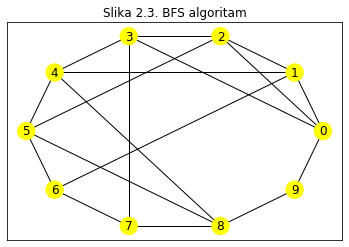

In [349]:
# generiram random povezan graf
graph_BFS = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 3, 0.7, np.random.randint(10000))

pos_graph_BFS = nx.shell_layout(graph_BFS)

# dohvacam podatke algoritama
podaci_BFS = BFS(graph_BFS, pocetni_cvor, ciljni_cvor)

# brojac za ispisivanje tablice
brojac_BFS = 0

broj_koraka_algoritma_BFS = len(podaci_BFS['put_obilaska'])

ispisi_output_BFS()

Sada kada smo se upoznali s radom *BFS* algoritma, opisat ćemo njegova svojstva.

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 2.6.** Za algoritam kažemo da je *potpun* ako i samo ako pronalazi rješenje uvijek kada ono postoji.

</div>

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 2.7.** Za algoritam kažemo da je *optimalan* ako i samo ako pronalazi optimalno rješenje (ono s najmanjom cijenom).

</div>

Sljedećom tablicom opisana su svojstva *BFS* algoritma:

In [350]:
stupci_tablice = ['Algoritam', 'Optimalnost', 'Potpunost', 'Prostorna složenost', 'Vremenska složenost']

# kreiram tablicu
tablica_svojstava_algoritama = pd.DataFrame([], columns=stupci_tablice)
#

# dodajem redak za BFS algoritam
red_vrijednosti = ['BFS','Da', 'Da', 
                '$\mathcal{O}(|V|) = \mathcal{O}(b^{d+1})$', 
                '$\mathcal{O}(|V|+|E|) = \mathcal{O}(b^{d+1})$']

red = pd.Series(red_vrijednosti, index=tablica_svojstava_algoritama.columns)
tablica_svojstava_algoritama = tablica_svojstava_algoritama.append(red, ignore_index=True)

display(tablica_svojstava_algoritama)

,Algoritam,Optimalnost,Potpunost,Prostorna složenost,Vremenska složenost
0,BFS,Da,Da,$\mathcal{O}(|V|) = \mathcal{O}(b^{d+1})$,$\mathcal{O}(|V|+|E|) = \mathcal{O}(b^{d+1})$


Dakle vidimo da je *BFS* algoritam potpun i optimalan. Također prostorna složenost ovisi samo o broju vrhova, dok vremenska složenost ovisi i o broju vrhova i o broju bridova. Ukoliko zapišemo složenosti u terminima $b$ i $d$, gdje je $b$ faktor grananja, a $d$ dubina optimalnog rješenja, vidimo da je prostorna i vremenska složenost eksponencijalna. Eksponencijalna prostorna složenost najveća je mana pretraživanja u širinu, pa se algoritam većinom primjenjuje na manje probleme.

### 2.2. Pretraživanje u dubinu

Jednu od prvih verzija algoritma *pretraživanja u dubinu* ili *DFS-a* (*Depth-first search*) istražio je u 19. stoljeću
francuski matematičar *Charles Pierre Trémaux* koji ga je također koristio za rješavanje problema pronalaska izlaska iz labirinta. Za razliku od svog 'bratskog' algoritma *BFS-a*, *DFS* istražuje, kao što samo ime kaže, u dubinu stabla obilaska. Dakle iz trenutnog čvora otići ćemo u susjedni čvor pa iz susjednog čvora u njegov susjedni čvor i tako dok ne dođemo do lista stabla. Pošto će ostali susjedni čvorovi morati 'čekati' da ih istražimo, ima smisla to što ćemo za strukturu podataka koristiti *stog* (*stack*).

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/7f/Depth-First-Search.gif",
         width=300, height=200>
    <em>Animacija 2.4. Pretraživanje u dubinu </em>
</div>

Algoritam je opisan sljedećim psuedokodom:
```python
def DFS_iterativni (graf, pocetni_cvor):
    s = Stack()
    s.push(pocetni_cvor)
    
    posjeceni_cvorovi[pocetni_cvor] = True
    
    while s.empty() == False:
        trenutni_cvor = s.pop()
        
        if posjeceni_cvorovi[trenutni_cvor] == False:
            posjeceni_cvorovi[trenutni_cvor] = True
            
            for susjedni_cvor in graf.susjedi(trenunti_cvor):
                s.push(susjedni_cvor)
```
Također algoritam je moguće implementirati rekurzivno:
```python
def DFS_rekurzivni (graf, trenutni_cvor):
    posjeceni_cvorovi[pocetni_cvor] = True
    
    if trenutni_cvor == ciljni_cvor
        return trenutni_cvor
    
    for susjedni_cvor in graf.susjedi(trenutni_cvor):
        if posjeceni_cvorovi[susjedni_cvor]  == False:
            DFS_rekurzivni(graf, susjedni_cvor])
```
U nastavku se nalazi implementacija *DFS* algoritma, te vizualizacija algoritma za svaki njegov korak. <br>
[Skok na DFS widget](#DFS_algoritam)

In [351]:
def DFS(graph, pocetni_cvor, ciljni_cvor, brojac=99999):
    # deklariram i inicijaliziram spremnike za algoritam
    s = Stack()
    s.push(pocetni_cvor)
    
    posjeceni_cvorovi = np.zeros(len(graph), dtype=bool)
    
    roditelj_cvora = np.zeros(len(graph), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;
    
    put_obilaska_stabla = Stack()
    
    # kreiram tablicu i dodajem red u nju
    tablica = pd.DataFrame([], columns=['Susjedni čvorovi', 'Trenutni čvor', 'Red', 'Lista posjećenih čvorova'])
    tablica = tablica.append(pd.Series(['-', '-', str(s), '-'], index=tablica.columns ), ignore_index=True)
    
    # algoritam staje ako je prioritetni red prazan ili za interektivni prikaz 
    # ako smo odradili zadani broj koraka
    while s.empty() == False and brojac != 0:
        trenutni_cvor = s.pop()
        
        if trenutni_cvor == ciljni_cvor:
            # dodajem cvor u stack i dodajem red u tablicu
            put_obilaska_stabla.push(trenutni_cvor)
            
            red = pd.Series(['-', str(trenutni_cvor), '-', str(put_obilaska_stabla)], index=tablica.columns )
            tablica = tablica.append(red, ignore_index=True)
            
            return {'put' : obrni_put(roditelj_cvora, pocetni_cvor, ciljni_cvor),
                    'put_obilaska' : put_obilaska_stabla.flip(),
                    'tablica' : tablica
                   }
        
        if posjeceni_cvorovi[trenutni_cvor] == False:
            posjeceni_cvorovi[trenutni_cvor] = True
            
            for susjedni_cvor in sorted(graph[trenutni_cvor], reverse = True):
                 if posjeceni_cvorovi[susjedni_cvor] == False:
                    roditelj_cvora[susjedni_cvor] = trenutni_cvor
                    s.push(susjedni_cvor)

        # dodajemo redak u tablicu s podacima ako nismo bili u tom cvoru do sada
        if put_obilaska_stabla.isin(trenutni_cvor) == False:
            put_obilaska_stabla.push(trenutni_cvor)
            
            red = pd.Series([str(sorted(graph[trenutni_cvor])), str(trenutni_cvor), 
                             str(s), str(put_obilaska_stabla)], index=tablica.columns) 
            tablica = tablica.append(red, ignore_index=True)
        
        brojac = brojac - 1
    
    return {'put_obilaska' : put_obilaska_stabla.flip(),
            'tablica' : tablica
           }

In [352]:
def ispisi_output_DFS():
    
    # brisem sve sto je ispisano u prijasnjem koraku
    clear_output(wait=True)
    
    # ispisujem gumbe na ekran
    display(HBox_DFS, output_DFS)

    # dohvacam podatke algoritama
    podaci_DFS = DFS(graph_DFS, pocetni_cvor, ciljni_cvor, brojac_DFS)
    
    # iscrtavam tablice
    display(podaci_DFS['tablica'])
    
    colors_DFS = [ 'yellow', 'red' ]
    
    # inicijaliziram boje cvorova za BFS
    posjeceni_DFS = np.zeros(len(graph_DFS), dtype=int)
    np.put(posjeceni_DFS, podaci_DFS['put_obilaska'], 1)
    
    node_colors_DFS = [ colors_DFS[posjeceni_DFS[i]] for i in range(len(graph_DFS)) ] 
        
    # crtam DFS graf
    nx.draw_networkx(graph_DFS, pos_graph_DFS, node_size=300, 
                     with_labels=True, node_color=node_colors_DFS)
    
    plt.title('Slika 2.4. DFS algoritam')
    
def sljedeci_DFS_clicked(b):
    global brojac_DFS
    
    # brojac ne moze biti veci od broja koraka algoritma 
    brojac_DFS = min(brojac_DFS + 1, broj_koraka_algoritma_DFS)
        
    ispisi_output_DFS()
        
def prethodni_DFS_clicked(b):
    global brojac_DFS

    # brojac ne moze biti manji od nule
    brojac_DFS = max(0, brojac_DFS - 1)
        
    ispisi_output_DFS()
    
# definiram gumbe
sljedeci_DFS = widgets.Button(description="Sljedeći korak")
prethodni_DFS = widgets.Button(description="Prethodni korak")
output_DFS = widgets.Output()
HBox_DFS = widgets.HBox([prethodni_DFS, sljedeci_DFS])

sljedeci_DFS.on_click(sljedeci_DFS_clicked)
prethodni_DFS.on_click(prethodni_DFS_clicked)

<a name="DFS_algoritam"></a>

Output()

,Susjedni čvorovi,Trenutni čvor,Red,Lista posjećenih čvorova
0,-,-,[1],-


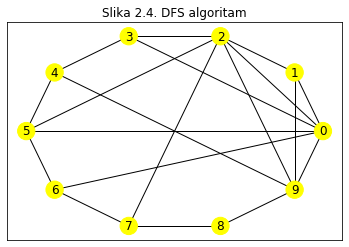

In [353]:
# generiram random povezan graf
graph_DFS = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 3, 0.7, np.random.randint(10000))

pos_graph_DFS = nx.shell_layout(graph_DFS)

# dohvacam podatke algoritama
podaci_DFS = BFS(graph_DFS, pocetni_cvor, ciljni_cvor)

# brojac za ispisivanje tablice
brojac_DFS = 0

broj_koraka_algoritma_DFS = len(podaci_DFS['put_obilaska'])

ispisi_output_DFS()

Kao što je *BFS* imao svoje mane, tako je teško očekivati da je *DFS* savršen. Zamislimo da stablo pretraživanja ima beskonačnu maksimalnu dubinu ili da koristimo verziju algoritma u kojem ne pamtimo čvorove koje smo posjetili, tada algoritam nikad neće završiti ili može zaglaviti u ciklusu, dakle *DFS* nije potpun. Također algoritam nije optimalan. To možemo vidjeti na sljedećem primjeru.

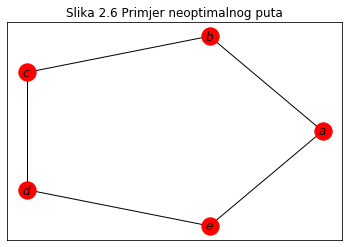

In [358]:
# inicijaliziramo graf
graf_neoptimalan = nx.Graph()
graf_neoptimalan.add_edges_from([(0, 1), (1, 2), (2, 3),  (3, 4), (0, 4)])

# postavimo labele
node_labels = { i : '$'+chr(97 + i)+'$' for i in range(5)}

# postavimo pozicije vrhovima
pos_graf_neoptimalan = nx.circular_layout(graf_neoptimalan)

#crtamo graf
nx.draw_networkx(graf_neoptimalan, pos_graf_neoptimalan, 
                 with_labels=True, labels=node_labels, node_color='red')
plt.title('Slika 2.6. Primjer neoptimalnog puta');

Pretpostavimo da imamo graf kao na gornjoj slici i zanima nas najkraći put od točke $a$ do točke $e$. Jasno je da je to put koji prolazi samo kroz vrhove $a$ i $e$, ali algoritam će vratiti put koji prolazi kroz vrhove $a$, $b$, $c$, $d$ i $e$. Proučimo još prostornu i vremensku složenost.

In [355]:
red_vrijednosti = ['DFS','Ne', 'Ne', 
                '$\mathcal{O}(|V|) = \mathcal{O}(bm)$', 
                '$\mathcal{O}(|V|+|E|) = \mathcal{O}(b^{m})$']

# dodajemo red u tablicu
red = pd.Series(red_vrijednosti, index=tablica_svojstava_algoritama.columns)
tablica_svojstava_algoritama = tablica_svojstava_algoritama.append(red, ignore_index=True)

display(tablica_svojstava_algoritama)

,Algoritam,Optimalnost,Potpunost,Prostorna složenost,Vremenska složenost
0,BFS,Da,Da,$\mathcal{O}(|V|) = \mathcal{O}(b^{d+1})$,$\mathcal{O}(|V|+|E|) = \mathcal{O}(b^{d+1})$
1,DFS,Ne,Ne,$\mathcal{O}(|V|) = \mathcal{O}(bm)$,$\mathcal{O}(|V|+|E|) = \mathcal{O}(b^{m})$


Gdje je $b$ faktor grananja, a $m$ maksimalna dubina stabla. *DFS* algoritam treba izbjegavati kada je maksimalna dubina stabla velika ili kada trebamo optimalno rješenje.<br>
Prisjetimo se našeg problema povezanosti grafova, *DFS* će zbog manje prostorne složenosti biti bolja opcija za provjeru tog svojstva grafa!
<br><br>
Sada kada smo upoznati s oba algoritma, usperdimo njihove korake na primjeru. <br>
[Skok na BFS/DFS widget](#BFS_DFS_algoritam)

In [356]:
def ispisi_output_BFS_DFS():
    
    # brisem sve sto je ispisano u prijasnjem koraku
    clear_output(wait=True)
    
    # ispisujem gumbe na ekran
    display(HBox_BFS_DFS, output_BFS_DFS)

    # dohvacam podatke algoritama
    podaci_BFS_DFS = {'BFS' : BFS(graph_BFS_DFS, pocetni_cvor, ciljni_cvor, brojac_BFS_DFS),
                      'DFS' : DFS(graph_BFS_DFS, pocetni_cvor, ciljni_cvor, brojac_BFS_DFS)
                     }
    
    # iscrtavam tablice
    print('BFS tablica podataka')
    display(podaci_BFS_DFS['BFS']['tablica'])
    print('DFS tablica podataka')
    display(podaci_BFS_DFS['DFS']['tablica'])
    
    colors_BFS_DFS = [ 'yellow', 'red' ]
    
    # inicijaliziram boje cvorova za BFS
    posjeceni_BFS = np.zeros(len(graph_BFS_DFS), dtype=int)
    np.put(posjeceni_BFS, podaci_BFS_DFS['BFS']['put_obilaska'], 1)
    
    node_colors_BFS = [ colors_BFS_DFS[posjeceni_BFS[i]] for i in range(len(graph_BFS_DFS)) ] 
    
    # inicijaliziram boje cvorova za DFS
    posjeceni_DFS = np.zeros(len(graph_BFS_DFS), dtype=int)
    np.put(posjeceni_DFS, podaci_BFS_DFS['DFS']['put_obilaska'], 1)
    
    node_colors_DFS = [ colors_BFS_DFS[posjeceni_DFS[i]] for i in range(len(graph_BFS_DFS)) ] 
    
    # crtam BFS graf
    plt.subplot(1, 2, 1)
    plt.title('BFS algoritam')
    nx.draw_networkx(graph_BFS_DFS, pos_graph_BFS_DFS, node_size=300, with_labels=True, node_color=node_colors_BFS)
    
    # crtam DFS graf
    plt.subplot(1, 2, 2)
    plt.title('DFS algoritam')
    nx.draw_networkx(graph_BFS_DFS, pos_graph_BFS_DFS, node_size=300, with_labels=True, node_color=node_colors_DFS)
    
def sljedeci_BFS_DFS_clicked(b):
    global brojac_BFS_DFS
    
    # brojac ne moze biti veci od broja koraka algoritma 
    brojac_BFS_DFS = min(brojac_BFS_DFS + 1, broj_koraka_algoritma_BFS_DFS)
        
    ispisi_output_BFS_DFS()
        
def prethodni_BFS_DFS_clicked(b):
    global brojac_BFS_DFS

    # brojac ne moze biti manji od nule
    brojac_BFS_DFS = max(0, brojac_BFS_DFS - 1)
        
    ispisi_output_BFS_DFS()
    
# definiram gumbe
sljedeci_BFS_DFS = widgets.Button(description="Sljedeći korak")
prethodni_BFS_DFS = widgets.Button(description="Prethodni korak")
output_BFS_DFS = widgets.Output()
HBox_BFS_DFS = widgets.HBox([prethodni_BFS_DFS, sljedeci_BFS_DFS])

sljedeci_BFS_DFS.on_click(sljedeci_BFS_DFS_clicked)
prethodni_BFS_DFS.on_click(prethodni_BFS_DFS_clicked)

<a name="BFS_DFS_algoritam"></a>

Output()

BFS tablica podataka


,Susjedni čvorovi,Trenutni čvor,Red,Lista posjećenih čvorova
0,-,-,[1],-


DFS tablica podataka


,Susjedni čvorovi,Trenutni čvor,Red,Lista posjećenih čvorova
0,-,-,[1],-


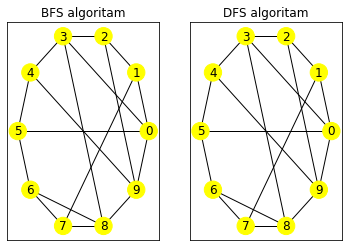

In [357]:
# generiram random povezan graf
graph_BFS_DFS = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 3, 0.7, np.random.randint(10000))

pos_graph_BFS_DFS = nx.shell_layout(graph_BFS_DFS)
nx.draw_networkx(graph_BFS_DFS, pos_graph_BFS_DFS, node_size=500, with_labels=True, node_color='red')

# dohvacam podatke algoritama
podaci_BFS_DFS = {'BFS' : BFS(graph_BFS_DFS, pocetni_cvor, ciljni_cvor),
                  'DFS' : DFS(graph_BFS_DFS, pocetni_cvor, ciljni_cvor)
                 }

# brojac za ispisivanje tablice
brojac_BFS_DFS = 0

broj_posjecenih_cvorova_BFS = len(podaci_BFS_DFS['BFS']['put_obilaska'])
broj_posjecenih_cvorova_DFS = len(podaci_BFS_DFS['DFS']['put_obilaska'])
                                  
broj_koraka_algoritma_BFS_DFS = max(broj_posjecenih_cvorova_BFS, broj_posjecenih_cvorova_DFS) + 1

ispisi_output_BFS_DFS()

## 3. Dijkstrin algoritam

<div style="background-color:Beige; padding: 5px 5px; margin: 10px 0px;">
    
**Definicija 3.1.** *Težina brida e* je numerička vrijednost $w(e)$ koja se pridružuje bridu. Graf kojemu su pridrućene težine zovemo *težinski graf*.

</div>


Do sada smo pretpostavljali da je cijena prelaska iz trenutnog čvora u susjedni jednaka u cijelom grafu, pa onda također i zanemariva. Ali što ako nam to nije slučaj? Zamislimo da putujemo iz Zagreba u London, sigurno nećemo vjerovat *DFS* algoritmu koji nije optimalan i putovat preko Moskve.

In [291]:
class PriorityQueue():
    def __init__(self, tip=np.dtype(np.int)): 
        self.keys = np.array([], dtype=tip) 
        self.values = np.array([], dtype=tip)
    
    # za koristenje print(class)
    def __str__(self):
        return str(np.vstack((self.keys, self.values)))
    
    # za koristenje display(class)
    def __repr__(self):
        return str(np.vstack((self.keys, self.values)))
    
    # sortira red po value vrijednosti
    def sort(self):
        mask = self.values.argsort()
        
        self.keys = self.keys[mask]
        self.values = self.values[mask]
    
    # provjerava je li red prazan
    def empty(self):
        return self.keys.size == 0
    
    # brise prvi element iz reda i vraca ga
    def pop(self):
        key = self.keys[0]
        value = self.values[0]
        
        self.keys = np.delete(self.keys, 0)
        self.values = np.delete(self.values, 0)
        return key, value
    
    # dodaje element u red
    def push(self, val):
        self.keys = np.insert(self.keys, 0, val[0])
        self.values = np.insert(self.values, 0, val[1])
        
        self.sort()
    
    # provjerava postoji li element s tim keyjem
    def isin(self, val):
        return np.any(np.isin(self.keys, val))
    
    # mijenja value za zadani key
    def set(self, key, val):
        try:
            pos = np.where(self.keys == key)[0][0]

            self.values[pos] = val
            self.sort()
        except:
            display("Element ne postoji!")

In [295]:
def Dijkstra(graph, pocetni_cvor, brojac=99999):
    
    # deklariram i inicijaliziram sve potrebne spremnike za algoritam
    udaljenosti = np.zeros(len(graph), dtype=int)
    roditelj_cvora = np.zeros(len(graph), dtype=int)
    posjeceni_cvorovi = np.zeros(len(graph), dtype=bool)
    
    roditelj_cvora[pocetni_cvor] = pocetni_cvor
    
    q = PriorityQueue()
    q.push((pocetni_cvor, 0))
    
    # dohvacam tezine
    weights = nx.get_edge_attributes(graph,'weight')
    
    # kreiram tablicu
    tablica = pd.DataFrame([], columns=['cvor', 'posjeceni', 'cijene', 'put'])
    
    # inicijaliziram potrebne spremnike i dodajem za svaki cvor red u tablicu
    for cvor in graph.nodes:
        if cvor != pocetni_cvor:
            # promjeni ovo kasnije
            udaljenosti[cvor] = 99999
            roditelj_cvora[cvor] = -1
            
            q.push((cvor, udaljenosti[cvor]))
        
        # red koji cu dodat u tablicu
        red = pd.Series([cvor, posjeceni_cvorovi[cvor], udaljenosti[cvor], roditelj_cvora[cvor]], 
                        index=tablica.columns 
                       )
        tablica = tablica.append(red, ignore_index=True)    
    
    # algoritam staje ako je prioritetni red prazan ili za interektivni prikaz 
    # ako smo odradili zadani broj koraka
    while q.empty() == False and brojac != 0:
        trenutni_cvor, value = q.pop()
        
        posjeceni_cvorovi[trenutni_cvor] = True
        
        # postavimo u tablici da je cvor posjecen
        tablica.at[trenutni_cvor, 'posjeceni'] = posjeceni_cvorovi[trenutni_cvor]
        
        for susjedni_cvor in sorted(graph[trenutni_cvor]):
            
            # graph[cvor] nije simetricna relacija
            # npr. imam (0, 1) ali nemam (1, 0), pa ovako izbjegavam pristup necemu sto nije definirano
            u = min(trenutni_cvor, susjedni_cvor)
            v = max(trenutni_cvor, susjedni_cvor)
            
            nova_udaljenost = udaljenosti[trenutni_cvor] + weights[u, v]
            if nova_udaljenost < udaljenosti[susjedni_cvor]:
                
                udaljenosti[susjedni_cvor] = nova_udaljenost
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                
                # azuriram tablicu
                tablica.at[susjedni_cvor, 'cijene'] = udaljenosti[susjedni_cvor]
                tablica.at[susjedni_cvor, 'put'] = roditelj_cvora[trenutni_cvor]
                
                q.set(susjedni_cvor, nova_udaljenost)
            
        brojac = brojac - 1
            
    return {'udaljenosti' : udaljenosti, 
            'roditelj_cvora' : roditelj_cvora, 
            'tablica' : tablica          
           }


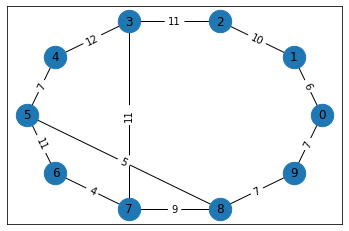

In [296]:
# generiram random povezan graf
graph_Dijkstra = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 2, 0.4, np.random.randint(10000))

for (u, v, w) in graph_Dijkstra.edges(data=True):
    w['weight'] = np.random.randint(1, 15)

pos_graph_Dijkstra = nx.shell_layout(graph_Dijkstra)
nx.draw_networkx(graph_Dijkstra, pos_graph_Dijkstra, node_size=500, with_labels=True)

weights = nx.get_edge_attributes(graph_Dijkstra,'weight')
nx.draw_networkx_edge_labels(graph_Dijkstra, pos_graph_Dijkstra, edge_labels=weights);

In [297]:
def ispisi_output_Dijkstra():

    # pobrisem sve sto je ispisano u prijasnjem koraku
    clear_output(wait=True)
    
    # ispisem gumbe na ekran
    display(HBox_Dijkstra, output_Dijkstra)
    
    # algoritam odraduje odredeni broj koraka
    podaci_Dijkstra = Dijkstra(graph_Dijkstra, 3, brojac_Dijkstra)
    display(podaci_Dijkstra['tablica'])
    
    # u cvorove upisujem do sad izracunatu udaljenost od pocetnog cvora
    cijene_Dijkstra = podaci_Dijkstra['tablica']['cijene']
    labels_map_Dijkstra = { i : cijene_Dijkstra[i] for i in range(len(graph_Dijkstra)) }
    
    # postavljam boje za cvorove
    colors_Dijkstra = ['yellow', 'red']
    posjeceni_Dijkstra = podaci_Dijkstra['tablica']['posjeceni']
    node_colors_Dijkstra = [ colors_Dijkstra[int(posjeceni_Dijkstra[i])] for i in range(len(graph_Dijkstra))]
    
    # crtam graf
    nx.draw_networkx(graph_Dijkstra, pos_graph_Dijkstra, node_size=500, 
            with_labels=True, labels=labels_map_Dijkstra, node_color=node_colors_Dijkstra)
    nx.draw_networkx_edge_labels(graph_Dijkstra, pos_graph_Dijkstra, edge_labels=weights);

def sljedeci_Dijkstra_clicked(b):
    global brojac_Dijkstra
    
    # brojac ne moze biti veci od broja koraka algoritma    
    brojac_Dijkstra = min(brojac_Dijkstra + 1, len(graph_Dijkstra))
        
    ispisi_output_Dijkstra()
        
def prethodni_Dijkstra_clicked(b):
    global brojac_Dijkstra
      
    # brojac ne moze biti manji od nule
    brojac_Dijkstra = max(0, brojac_Dijkstra - 1)
        
    ispisi_output_Dijkstra()

# definiram gumbe
sljedeci_Dijkstra = widgets.Button(description=">")
prethodni_Dijkstra = widgets.Button(description="<")
output_Dijkstra = widgets.Output()
HBox_Dijkstra = widgets.HBox([prethodni_Dijkstra, sljedeci_Dijkstra])

# gumbima zadajem funkcije koje ce se izvrsiti na event
sljedeci_Dijkstra.on_click(sljedeci_Dijkstra_clicked)
prethodni_Dijkstra.on_click(prethodni_Dijkstra_clicked)

Output()

,cvor,posjeceni,cijene,put
0,0,False,99999,-1
1,1,False,99999,-1
2,2,False,99999,-1
3,3,False,0,3
4,4,False,99999,-1
5,5,False,99999,-1
6,6,False,99999,-1
7,7,False,99999,-1
8,8,False,99999,-1
9,9,False,99999,-1


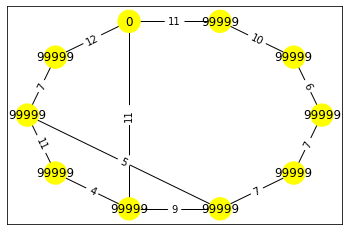

In [298]:
brojac_Dijkstra = 0;

ispisi_output_Dijkstra()

In [299]:
def A_star(graph, pocetni_cvor, ciljni_cvor, h, brojac=9999):   
    # deklariram i inicijaliziram sve potrebne spremnike za algoritam
    h_val = [ h(pos_graph_A_star[i], pos_graph_A_star[ciljni_cvor]) for i in range(len(graph)) ]
    
    p = PriorityQueue()
    p.push((pocetni_cvor, h_val[pocetni_cvor]))
    
    posjeceni_cvorovi = np.zeros(len(graph), dtype=bool)
    
    roditelj_cvora = np.zeros(len(graph), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor
        
    najkraca_udaljenost = np.zeros(len(graph), dtype=int)
    najkraca_udaljenost[pocetni_cvor] = 0
    
    ukupna_udaljenost = np.zeros(len(graph), dtype=float)
    ukupna_udaljenost[pocetni_cvor] = najkraca_udaljenost[pocetni_cvor] + h_val[pocetni_cvor]

    # dohvacam tezine i inicijaliziram brojac koji ce mi kasnije trebati za interaktivni prikaz
    weights = nx.get_edge_attributes(graph, 'weight')
    broj_koraka_algoritma = 0
    
    # kreiram tablicu
    tablica = pd.DataFrame([], columns=['cvor', 'posjeceni', 'udaljenost', 'heuristika', 'ukupna udaljenost', 'roditelj'])
    
    # inicijaliziram potrebne spremnike i dodajem za svaki cvor red u tablicu
    for cvor in graph.nodes:
        if cvor != pocetni_cvor:
            najkraca_udaljenost[cvor] = 99999
            ukupna_udaljenost[cvor] = 99999
            roditelj_cvora[cvor] = -1
        
        # red koji cu dodati u tablicu
        red = pd.Series([cvor, 
                         posjeceni_cvorovi[cvor], 
                         najkraca_udaljenost[cvor], 
                         h_val[cvor], 
                         ukupna_udaljenost[cvor], 
                         roditelj_cvora[cvor]], index=tablica.columns 
                       )
        
        # dodajem u tablicu red
        tablica = tablica.append(red, ignore_index=True) 
    
    # algoritam staje ako je prioritetni red prazan ili za interektivni prikaz 
    # ako smo odradili zadani broj koraka
    while p.empty() == False and brojac != 0:
        trenutni_cvor, value = p.pop()
        posjeceni_cvorovi[trenutni_cvor] = True
        
        # azuriram tablicu 
        tablica.at[trenutni_cvor, 'posjeceni'] = posjeceni_cvorovi[trenutni_cvor]
        
        broj_koraka_algoritma = broj_koraka_algoritma + 1
        
        if trenutni_cvor == ciljni_cvor:
            return {'broj_koraka_algoritma' : broj_koraka_algoritma,
                    'put' : obrni_put(roditelj_cvora, pocetni_cvor, ciljni_cvor),
                    'tablica' : tablica 
                   }
        
        for susjedni_cvor in sorted(graph[trenutni_cvor]):
            
            # graph[cvor] nije simetricna relacija
            # npr. imam (0, 1) ali nemam (1, 0), pa ovako izbjegavam pristup necemu sto nije definirano
            u = min(trenutni_cvor, susjedni_cvor)
            v = max(trenutni_cvor, susjedni_cvor)
            
            nova_udaljenost = najkraca_udaljenost[trenutni_cvor] + weights[u, v]
            if nova_udaljenost < najkraca_udaljenost[susjedni_cvor]:
                
                roditelj_cvora[susjedni_cvor] = trenutni_cvor

                najkraca_udaljenost[susjedni_cvor] = nova_udaljenost
                ukupna_udaljenost[susjedni_cvor] = nova_udaljenost + h_val[susjedni_cvor]
                
                # azuriram tablicu
                tablica.at[susjedni_cvor, 'roditelj'] = roditelj_cvora[susjedni_cvor]
                tablica.at[susjedni_cvor, 'udaljenost'] = najkraca_udaljenost[susjedni_cvor]
                tablica.at[susjedni_cvor, 'ukupna udaljenost'] = ukupna_udaljenost[susjedni_cvor]
                
                if posjeceni_cvorovi[susjedni_cvor] == False:
                    p.push((susjedni_cvor, ukupna_udaljenost[susjedni_cvor]))
                    
        brojac = brojac - 1

    # ne vracam najkraci put jer nije izracunat!
    return {'broj_koraka_algoritma' : broj_koraka_algoritma, 
            'tablica' : tablica 
           }

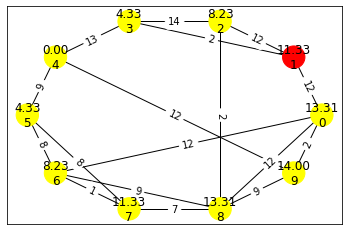

In [300]:
# generiram random povezan graf
graph_A_star = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 3, 0.7, np.random.randint(10000))

# definiram heuristiku
alfa = 7
h = lambda a, b : np.linalg.norm(b - a) * alfa
    
# definiram pozicije
pos_graph_A_star = nx.shell_layout(graph_A_star)

# definiram labele, u cvoru ce pisat vrijednost heuristike i ime čvora
labels_map_A_star = {i : format(h(pos_graph_A_star[i], pos_graph_A_star[ciljni_cvor]), '.2f')+"\n"+str(i) 
                    for i in range(len(graph_A_star))}

# postavljam boju cvorova u zuto i pocetni cvor u crveno
node_colors_A_star = ['yellow' for i in range(len(graph_A_star))]
node_colors_A_star[pocetni_cvor]='red'

# crtam graf
nx.draw_networkx(graph_A_star, pos_graph_A_star, node_size=500, with_labels=True, 
        node_color=node_colors_A_star, labels=labels_map_A_star)

# dodajem tezine
for (u, v, w) in graph_A_star.edges(data=True):
    w['weight'] = np.random.randint(1, 15)

#crtam tezine
weights = nx.get_edge_attributes(graph_A_star,'weight')
nx.draw_networkx_edge_labels(graph_A_star, pos_graph_A_star, edge_labels=weights);

In [301]:
def ispisi_output_A_star():    
    # brisem sve sto je ispisano u prijasnjem koraku
    clear_output(wait=True)
    
    # ispisujem gumbe na ekran
    display(HBox_A_star, output_A_star)
    display(najkraci_put_A_star)
    
    # algoritam odraduje odreden broj koraka
    podaci_A_star = A_star(graph_A_star, pocetni_cvor, ciljni_cvor, h, brojac_A_star);
    display(podaci_A_star['tablica'])
    
    # postavljam boje za cvorove
    colors_A_star = ['yellow', 'red']
    posjeceni_A_star = podaci_A_star['tablica']['posjeceni']
    node_colors_A_star = [ colors_A_star[int(posjeceni_A_star[i])] for i in range(len(graph_A_star))]
    
    # crtam graf
    nx.draw_networkx(graph_A_star, pos_graph_A_star, node_size=500, with_labels=True, node_color=node_colors_A_star)
    nx.draw_networkx_edge_labels(graph_A_star, pos_graph_A_star, edge_labels=weights);
    
def sljedeci_A_star_clicked(b):
    global brojac_A_star
    
    # brojac ne moze biti veci od broja koraka algoritma
    brojac_A_star = min(brojac_A_star + 1, broj_koraka_algoritma_A_star)

    ispisi_output_A_star()
        
def prethodni_A_star_clicked(b):
    global brojac_A_star
        
    # brojac ne moze biti manji od nule
    brojac_A_star = max(0, brojac_A_star - 1)
        
    ispisi_output_A_star()
    
# definiram gumbe
sljedeci_A_star = widgets.Button(description=">")
prethodni_A_star = widgets.Button(description="<")
output_A_star = widgets.Output()
HBox_A_star = widgets.HBox([prethodni_A_star, sljedeci_A_star])

# gumbima zadajem funkcije koje ce se izvrsiti na event
sljedeci_A_star.on_click(sljedeci_A_star_clicked)
prethodni_A_star.on_click(prethodni_A_star_clicked)

Output()

[1 3 4]

,cvor,posjeceni,udaljenost,heuristika,ukupna udaljenost,roditelj
0,0,False,99999,13.314792,99999.000000,-1
1,1,False,0,11.326238,11.326238,1
2,2,False,99999,8.228994,99999.000000,-1
3,3,False,99999,4.326238,99999.000000,-1
4,4,False,99999,0.000000,99999.000000,-1
5,5,False,99999,4.326238,99999.000000,-1
6,6,False,99999,8.228994,99999.000000,-1
7,7,False,99999,11.326238,99999.000000,-1
8,8,False,99999,13.314792,99999.000000,-1
9,9,False,99999,14.000000,99999.000000,-1


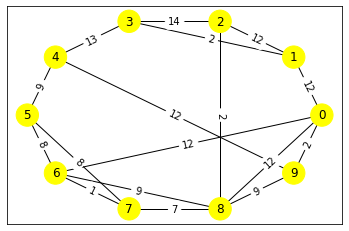

In [302]:
# dohvacam podatke, ne znam potreban broj koraka za algoritam
# pa ga pozivam jednom da ih izracuna i da  dohvatim ostale podatke
podaci_A_star = A_star(graph_A_star, pocetni_cvor, ciljni_cvor, h)
broj_koraka_algoritma_A_star = podaci_A_star['broj_koraka_algoritma']
najkraci_put_A_star = podaci_A_star['put']

brojac_A_star = 0;

# funkcija za ispis
ispisi_output_A_star()